In [1]:
from comet_ml import Experiment, Optimizer

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import trange
import torch
import seaborn as sns
import os
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import sklearn
import time
import datetime

plt.style.use("seaborn")
torch.set_default_dtype(torch.float32)

In [3]:
import node

In [4]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

In [5]:
from tabular_hypernet import HypernetworkPCA, TrainingModes, Hypernetwork
from tabular_hypernet.modules import SimpleNetwork
from tabular_hypernet.training_utils import train_slow_step, train_model, train_carthesian
from tabular_hypernet.interfaces import HypernetworkSklearnInterface, SimpleSklearnInterface
# from ipynb.fs.defs.MNIST_benchmark import test_model

In [6]:
import pyhopper

In [7]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

1

In [8]:
DEVICE = 'cuda:0'

In [9]:
DATA = "Glass"

## Load data

In [10]:
if DATA == "BreastCancer":
    dataset = sklearn.datasets.load_breast_cancer()
    X = dataset['data']
    y = dataset['target']
elif DATA == "Sonar":
    dataset = pd.read_csv("../data/sonar/sonar.all-data", header=None)
    X = dataset.values[:, :-1].astype(float)
    y = dataset.values[:, -1]
    y = LabelEncoder().fit_transform(y)
elif DATA == "Dermatology":
    dataset = pd.read_csv("../data/dermatology/dermatology.data", header=None, na_values="?").dropna()
    X = dataset.values[:, :-1].astype(float)
    y = dataset.values[:, -1].astype(int)
elif DATA == "Flag":
    dataset = pd.read_csv("../data/flag/flag.data", header=None)
    X = dataset.values[:, 7:]
    y = dataset.values[:, 6].astype(int)

    X[:, -1] = LabelEncoder().fit_transform(X[:, -1])
    X[:, -2] = LabelEncoder().fit_transform(X[:, -2])
    X[:, 10] = LabelEncoder().fit_transform(X[:, 10])
    y = LabelEncoder().fit_transform(y).astype(int)
    
    X = X.astype(np.float32)
elif DATA == "Glass":
    dataset = pd.read_csv("../data/glass/glass.data", header=None, na_values="?").dropna()
    X = dataset.values[:, :-1].astype(float)
    y = dataset.values[:, -1].astype(int)
    y = LabelEncoder().fit_transform(y).astype(int)

max_size = int(len(X)*0.7)
print(X.shape, len(np.unique(y)), max_size)

(214, 10) 6 149


## Preprocess

In [11]:
import imblearn
np.random.seed(42)

def prepare_data(X, y, size=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y)
    # X_train, y_train = imblearn.over_sampling.RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]
    
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = prepare_data(X, y, size=100)

## Benchmark

In [13]:
criterion = torch.nn.CrossEntropyLoss()

In [14]:
def _summarize_results(y_pred, y_score, y_test, labels):
    results = []
    for idx, label in enumerate(labels):
        y_pred_filt = y_pred[y_test==idx]
        y_test_filt = y_test[y_test==idx]
        acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
        results.append({
            "Class": label,
            "Metric": acc
        })
        
    acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100    
    results.append({
        "Class": "Total",
        "Metric": acc
    })
    try:
        results.append({
            "Class": "F1 score",
            "Metric": f1_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "ROC score",
            "Metric": roc_auc_score(y_test, torch.from_numpy(y_score[:, 1])).item()*100
        })
        results.append({
            "Class": "Precision",
            "Metric": precision_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "Recall",
            "Metric": recall_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
    except ValueError:
        pass
    return results

def test_model(model_fn, data, train_size, label_encoder=None, iters=10, as_numpy=False):
    if label_encoder is not None:
        labels = label_encoder.classes_
    else:
        labels = sorted(pd.unique(data[1]))
    
    results = []

    for i in range(iters):
        X_train, X_test, y_train, y_test = prepare_data(*data, train_size)
        
        model = model_fn()

        if as_numpy:
            model.fit(X_train.numpy(), y_train.numpy());
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        results.extend(_summarize_results(y_pred, y_score, y_test, labels))

    dframe = pd.DataFrame.from_dict(results)
    sns.violinplot(data=dframe[dframe["Class"]!="Loss"], y="Class", x="Metric", orient='h')
    return dframe

### XGBoost

In [15]:
from xgboost import XGBClassifier

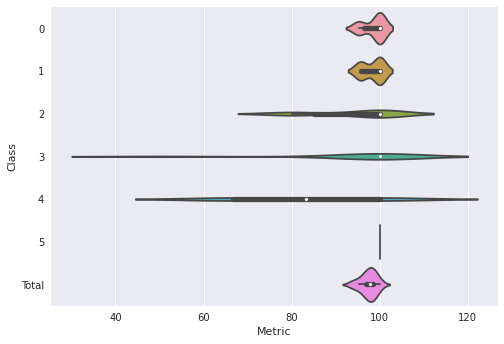

In [16]:
def get_xgboost():
    random_seed = np.random.randint(1024)
    return XGBClassifier(
        verbosity=0,
        random_state=random_seed,
        subsample=0.98,
        learning_rate=0.01,
        max_depth=6,
        use_label_encoder=False)

data_size = max_size

xgb_dframe = test_model(get_xgboost,
                        (X, y),
                        data_size,
                        label_encoder=None, iters=10)

In [17]:
res = xgb_dframe[xgb_dframe["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

149: 97.38 ~ 1.78 (max: 100.00)


### NODE

In [19]:
from qhoptim.pyt import QHAdam

In [20]:
def node_fn(layer_dims):
    def _inner():
        network = torch.nn.Sequential(
            node.DenseBlock(X_train.shape[1], layer_dims, num_layers=1, tree_dim=7, depth=3, flatten_output=False,
                           choice_function=node.entmax15, bin_function=node.entmoid15),
            node.Lambda(lambda x: x.mean(dim=1))
        )
        
        with torch.no_grad():
            res = network(torch.as_tensor(X_train[:1000], device='cpu').to(torch.float32))
        
        network = network.to(DEVICE)
        network.device=DEVICE
            
        optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
        optim = QHAdam(network.parameters(), **optimizer_params)
            
        network = SimpleSklearnInterface(network, device=DEVICE, epochs=150, batch_size=32)
        network.optimizer = optim
        return network
    return _inner

In [21]:
%%capture --no-stdout

for size in [max_size]:
    node_results = test_model(node_fn(128),
                        (X, y),
                        size,
                        label_encoder=None, iters=10)
    res = node_results[node_results["Class"]=="ROC score"].reset_index(drop=True)["Metric"]
    print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

149: nan ~ nan, (max: nan)


In [23]:
res = node_results[node_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

149: 73.54 ~ 3.31, (max: 78.46)


In [137]:
res = node_results[node_results["Class"]=="ROC score"].reset_index(drop=True)["Metric"]

In [24]:
node_results[node_results["Class"]=="ROC score"].reset_index(drop=True)

,Class,Metric


### Neural network

In [43]:
def network_fn():
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(1-7/10),
                        torch.nn.Linear(10, 50),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(0.5),
                        torch.nn.Linear(50, 6)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=150, batch_size=32)
        return network
    return _inner

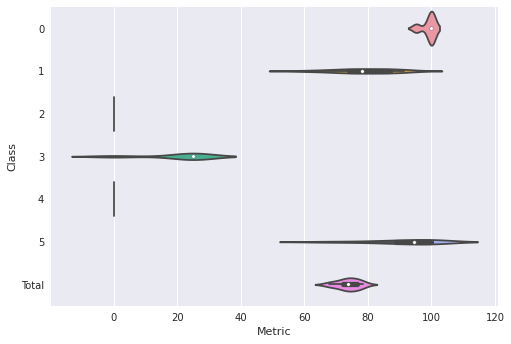

In [44]:
data_size = max_size

nn_results = test_model(network_fn(),
                (X, y),
                data_size,
                None, 10)

In [45]:
res = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

149: 73.69 ~ 3.44 (max: 78.46)


### HypernetworkPCA

In [30]:
def network_pca_fn(target_size, mask_size, masks_no=100):
    def _inner():
        hypernet = HypernetworkPCA(
                        target_architecture=[(mask_size, target_size), (target_size, 7)], 
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(5, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                        input_size=10
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=64)
        return network
    return _inner

In [25]:
def figure_to_html():
    tmpfile = BytesIO()
    plt.gcf().savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    return html

torch.Size([1, 128])
10


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.22it/s]


torch.Size([1, 128])
10


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


torch.Size([1, 128])
10


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


torch.Size([1, 128])
10


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


torch.Size([1, 128])
10


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


torch.Size([1, 128])
10


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.45it/s]


torch.Size([1, 128])
10


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


torch.Size([1, 128])
10


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.39it/s]


torch.Size([1, 128])
10


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


torch.Size([1, 128])
10


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


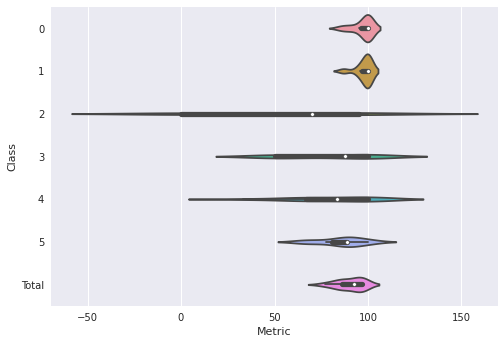

In [29]:
epochs = 100
masks_no = 20
mask_size = 3
target_size = 20
data_size = max_size

nn_results = test_model(network_pca_fn(target_size, mask_size, masks_no),
                (X, y),
                data_size,
                None, 10)

# exp.log_table("metrics.csv", nn_results.groupby("Class").mean())
# exp.log_metric("f1_score", nn_results.groupby("Class").mean().loc["F1 score"])

In [31]:
res = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

149: 90.31 ~ 7.07 (max: 96.92)


In [ ]:
mask_size = 5
total = 15
current = 0

res = {}
for epochs in [100, 150, 200, 300, 500]:
    for masks_no in [50, 30, 70]:
        current += 1
        description = f"{epochs=}, {mask_size=}, {masks_no=}"
        exp = Experiment(os.environ.get("COMET_KEY"), "blastchar-hypernet")

        nn_results = test_model(network_fn(epochs, mask_size, masks_no),
                        (X, y),
                        y_label_enc, 4, data_size=100)

        exp.log_parameters({"epochs": epochs, "mask_size": mask_size, "masks_no": masks_no})
        exp.add_tag("hypernet-full-optim")
        exp.log_table("metrics.csv", nn_results.groupby("Class").mean())
        exp.log_metric("f1_score", nn_results.groupby("Class").mean().loc["F1 score"])

        res[description] = nn_results
        logger.info(description)
        logger.info(f"{current}/{total}")
        print_statistics(res[description])

In [70]:
for key in res.keys():
    print(key)
    print_statistics(res[key])

epochs=100, mask_size=5, masks_no=50
F1: 60.890 ~ 1.154
C-statistics: 83.136 ~ 0.376
Precision: 53.227 ~ 5.449
Recall: 72.538 ~ 8.134
epochs=100, mask_size=5, masks_no=30
F1: 60.464 ~ 1.268
C-statistics: 82.603 ~ 0.516
Precision: 49.242 ~ 4.728
Recall: 79.565 ~ 7.094
epochs=100, mask_size=5, masks_no=70
F1: 49.704 ~ 10.204
C-statistics: 82.516 ~ 1.119
Precision: 65.107 ~ 6.064
Recall: 43.269 ~ 17.677


In [66]:
exp.run_id

'RKwbRoPWKvsMjkjK3JobL0J5e'

### Hypernetwork

In [16]:
def network_fn(epochs=150, masks_no=100, mask_size=100, target_size=100):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, 6)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(10, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=64)
        return network
    return _inner

#### Find hyperparams

In [17]:
epochs = 100
mask_size = 10
masks_no = 80
data_size = max_size
results = defaultdict(dict)


def objective(params):
    epochs = params['epochs']
    masks_no = params['masks_no']
    mask_size = params['mask_size']
    target_size = params['target_size']
    print("Training...")
    nn_results = test_model(network_fn(epochs, masks_no, mask_size, target_size),
                    (X, y),
                    data_size,
                    None, 4)
    with open("sonar_params.txt", "a") as f:
        f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
    return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]

from pyhopper.callbacks import History
search = pyhopper.Search(
    {
        "epochs": pyhopper.int(50, 150, multiple_of=10),
        "masks_no": pyhopper.int(20, 100, multiple_of=10),
        "mask_size": pyhopper.int(2, 8),
        "target_size": pyhopper.choice([10, 20, 50, 100]),
    }
)

# An run the optimization for 60 minutes
best_params = search.run(objective, "maximize", "30m", n_jobs="2x per-gpu", seeding_ratio=0.5)

  0%|          | [00:00<?]

Search is scheduled for 30:00 (m:s)
Training...Training...Training...Training...Training...Training...Training...




Training...


torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])torch.Size([1, 128])torch.Size([1, 128])
torch.Size([1, 128])torch.Size([1, 128])torch.Size([1, 128])







100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.44it/s]

 58%|███████████████████████████████████████████████▌                                  | 58/100 [00:34<00:23,  1.80it/s]

torch.Size([1, 128])


 39%|████████████████████████████████▏                                                 | 51/130 [00:34<00:52,  1.49it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:37<00:00,  1.84it/s]

 43%|███████████████████████████████████▎                                              | 56/130 [00:38<00:48,  1.53it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [00:43<00:00,  3.24it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [00:45<00:00,  3.29it/s]

 20%|████████████████▌                                                                  | 14/70 [00:07<00:30,  1.86it/s]

torch.Size([1, 128])


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:45<00:00,  1.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:45<00:00,  1.30it/s]

 77%|███████████████████████████████████████████████████████████████▏                  | 77/100 [00:46<00:13,  1.70it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


torch.Size([1, 128])

100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [01:00<00:00,  2.17it/s]

 68%|████████████████████████████████████████████████████████▏                         | 89/130 [00:59<00:27,  1.50it/s]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.49it/s]

 50%|█████████████████████████████████████████▌                                         | 30/60 [00:22<00:22,  1.34it/s]


torch.Size([1, 128])

 51%|█████████████████████████████████████████▌                                        | 76/150 [00:22<00:23,  3.18it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:37<00:00,  1.87it/s]

 75%|████████████████████████████████████████████████████████████▊                    | 105/140 [00:32<00:10,  3.23it/s]


torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [00:42<00:00,  3.26it/s]

 89%|████████████████████████████████████████████████████████████████████████▎        | 134/150 [00:40<00:04,  3.40it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [01:27<00:00,  1.49it/s]


torch.Size([1, 128])


 45%|████████████████████████████████████▌                                             | 58/130 [00:27<00:35,  2.04it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [00:45<00:00,  3.29it/s]

 11%|█████████▎                                                                        | 16/140 [00:05<00:36,  3.39it/s]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:45<00:00,  1.32it/s]

 66%|██████████████████████████████████████████████████████▊                            | 33/50 [00:23<00:12,  1.37it/s]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.41it/s]

 27%|█████████████████████▊                                                            | 40/150 [00:12<00:32,  3.35it/s]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:38<00:00,  1.82it/s]

 49%|███████████████████████████████████████▉                                          | 73/150 [00:22<00:22,  3.38it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s]



torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [01:01<00:00,  2.12it/s]

 79%|████████████████████████████████████████████████████████████████▏                | 111/140 [00:34<00:09,  3.21it/s]


torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [00:44<00:00,  3.17it/s]

 83%|█████████████████████████████████████████████████████████████████████▏             | 50/60 [00:38<00:07,  1.32it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [00:46<00:00,  3.25it/s]


torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:46<00:00,  1.30it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:33<00:00,  1.44it/s]


torch.Size([1, 128])

 28%|██████████████████████▋                                                           | 36/130 [00:16<00:42,  2.19it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.46it/s]

  2%|█▍                                                                                  | 1/60 [00:00<00:43,  1.35it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]

 29%|███████████████████████▉  

Training...
torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:37<00:00,  1.85it/s]

 50%|█████████████████████████████████████████                                         | 70/140 [00:21<00:20,  3.46it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


torch.Size([1, 128])


 75%|█████████████████████████████████████████████████████████████                    | 113/150 [00:35<00:11,  3.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [00:43<00:00,  3.21it/s]

 46%|█████████████████████████████████████▋                                            | 46/100 [00:35<00:41,  1.29it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
 

Training...
torch.Size([1, 128])

 79%|███████████████████████████████████████████████████████████████▋                 | 118/150 [00:36<00:09,  3.37it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [01:29<00:00,  1.46it/s]

 94%|█████████████████████████████████████████████████████████████████████████████     | 94/100 [00:56<00:03,  1.69it/s]

torch.Size([1, 128])

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [01:00<00:00,  2.13it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▏   | 143/150 [00:44<00:02,  3.23it/s]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:46<00:00,  1.30it/s]

  9%|███████▌                                                                          | 12/130 [00:07<01:16,  1.54it/s]
/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [00:46<00:00,  3.27it/s]/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
 

Training...

100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [00:46<00:00,  3.21it/s]



torch.Size([1, 128])



  0%|                                                                                           | 0/140 [00:00<?, ?it/s]
/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
  4%|███▏                                                                               | 5/130 [00:02<00:55,  2.24it/s]/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]

 48%|███████████████████████████████████████▏                                          | 67/140 [00:30<00:34,  2.11it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]

 72%|███████████████████████████████████████████████████████████▎                      | 94/130 [01:03<00:24,  1.47it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])

100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [00:59<00:00,  2.19it/s]

  6%|████▊                                                                               | 4/70 [00:01<00:25,  2.56it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [01:08<00:00,  1.32it/s]

  9%|███████▏                                                                            | 6/70 [00:02<00:25,  2.51it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [01:02<00:00,  2.24it/s]



torch.Size([1, 128])

 99%|███████████████████████████████████████████████████████████████████████████████▊ | 138/140 [01:35<00:01,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [01:36<00:00,  1.45it/s]

  2%|█▊                                                                                 | 3/140 [00:01<00:58,  2.33it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [01:04<00:00,  2.17it/s]

  9%|███████▍                                                                            | 8/90 [00:06<01:03,  1.29it/s]

torch.Size([1, 128])



 20%|████████████████▍                                                                 | 28/140 [00:12<00:52,  2.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [01:28<00:00,  1.47it/s]

 24%|███████████████████▉                                                              | 34/140 [00:15<00:49,  2.15it/s]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:26<00:00,  2.62it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]

 66%|██████████████████████████████████████████████████████▍                           | 93/140 [00:58<00:48,  1.03s/it]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:43<00:00,  1.63it/s]

 69%|████████████████████████████████████████████████████████▏                         | 96/140 [01:00<00:42,  1.04it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [01:38<00:00,  1.42it/s]


torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [01:43<00:00,  1.15s/it]

 64%|████████████████████████████████████████████████████▋                             | 90/140 [01:37<01:09,  1.39s/it]

torch.Size([1, 128])

100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [01:40<00:00,  1.40it/s]

  2%|█▊                                                                                  | 2/90 [00:02<02:10,  1.48s/it]

torch.Size([1, 128])


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:49<00:00,  1.41it/s]

 14%|███████████▏                                                                      | 19/140 [00:13<00:58,  2.05it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [02:26<00:00,  1.22s/it]

 34%|████████████████████████████                                                      | 48/140 [00:39<01:20,  1.15it/s]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:48<00:00,  1.44it/s]

 52%|██████████████████████████████████████████▊                                       | 73/140 [00:59<00:59,  1.13it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [02:40<00:00,  1.15s/it]

 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [01:42<00:40,  1.40s/it]


torch.Size([1, 128])

 12%|██████████▎                                                                       | 15/120 [00:20<02:31,  1.44s/it]


100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [02:39<00:00,  1.23s/it]

 65%|█████████████████████████████████████████████████████▎                            | 91/140 [01:15<00:42,  1.14it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]



Training...


 69%|████████████████████████████████████████████████████████▏                         | 96/140 [01:19<00:39,  1.12it/s]


torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]

 88%|███████████████████████████████████████████████████████████████████████▏         | 123/140 [01:44<00:14,  1.15it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [01:58<00:00,  1.18it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [02:00<00:00,  1.17it/s]

  4%|███▌                                                                               | 6/140 [00:05<01:54,  1.17it/s]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [02:11<00:00,  1.46s/it]

 49%|████████████████████████████████████████▎                                         | 59/120 [01:28<01:33,  1.53s/it]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:55<00:00,  1.09it/s]

  8%|██████▍                                                                           | 11/140 [00:10<02:05,  1.02it/s]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:49<00:00,  1.22it/s]

 50%|█████████████████████████████████████████                                         | 70/140 [00:59<00:38,  1.82it/s]

torch.Size([1, 128])


 52%|██████████████████████████████████████████▋                                       | 52/100 [01:15<00:51,  1.07s/it]


100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [02:59<00:00,  1.50s/it]

 77%|███████████████████████████████████████████████████████████████▏                  | 77/100 [01:54<00:26,  1.15s/it]


torch.Size([1, 128])

 69%|█████████████████████████████████████████████████████████▏                         | 62/90 [01:30<00:31,  1.12s/it]


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:46<00:00,  1.29it/s]

 99%|████████████████████████████████████████████████████████████████████████████████▍| 139/140 [01:51<00:00,  2.22it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [01:52<00:00,  1.24it/s]

  2%|█▍                                                                                  | 1/60 [00:00<00:24,  2.43it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [01:51<00:00,  1.25it/s]

 69%|████████████████████████████████████████████████████████▏                        | 104/150 [02:52<00:40,  1.14it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])


 89%|█████████████████████████████████████████████████████████████████████████▊         | 80/90 [01:43<00:07,  1.39it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [02:54<00:00,  1.24s/it]

  3%|██▊                                                                                | 4/120 [00:01<00:53,  2.18it/s]

torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]

 96%|███████████████████████████████████████████████████████████████████████████████▎   | 86/90 [01:48<00:03,  1.32it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])

100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [01:51<00:00,  1.24s/it]

  6%|████▋                                                                              | 8/140 [00:05<01:32,  1.43it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.20it/s]

 39%|████████████████████████████████▏                                                 | 51/130 [00:26<00:41,  1.91it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [03:34<00:00,  1.43s/it]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [00:56<00:00,  2.14it/s]

 56%|█████████████████████████████████████████████▋                                    | 78/140 [00:54<00:42,  1.46it/s]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 80/80 [00:54<00:00,  1.46it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [01:09<00:00,  1.88it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [01:31<00:00,  1.31it/s]

 41%|█████████████████████████████████▍                                                | 49/120 [00:22<00:32,  2.21it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]

 21%|█████████████████                                                                 | 25/120 [00:18<01:10,  1.35it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 140/140 [01:36<00:00,  1.44it/s]

 51%|█████████████████████████████████████████▋                                        | 66/130 [00:34<00:34,  1.87it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 110/110 [01:39<00:00,  1.11it/s]

 32%|█████████████████████████▉                                                        | 38/120 [00:28<01:01,  1.34it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [00:55<00:00,  2.18it/s]

 69%|████████████████████████████████████████████████████████▊                         | 90/130 [00:46<00:21,  1.89it/s]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 80/80 [00:54<00:00,  1.47it/s]

 41%|█████████████████████████████████▍                                                | 49/120 [00:15<00:21,  3.30it/s]


torch.Size([1, 128])

 74%|████████████████████████████████████████████████████████████▌                     | 96/130 [00:50<00:17,  1.94it/s]


 22%|██████████████████                                                                | 22/100 [00:16<00:59,  1.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [01:07<00:00,  1.92it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [00:37<00:00,  3.22it/s]



torch.Size([1, 128])

 64%|████████████████████████████████████████████████████▌                             | 77/120 [00:57<00:31,  1.36it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [00:54<00:00,  2.18it/s]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 92/100 [01:08<00:06,  1.33it/s]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 80/80 [00:54<00:00,  1.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [01:29<00:00,  1.34it/s]

 62%|██████████████████████████████████████████████████▋                               | 68/110 [01:01<00:39,  1.06it/s]

torch.Size([1, 128])

 54%|████████████████████████████████████████████▏                                     | 70/130 [00:36<00:32,  1.84it/s]
/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]
  0%|                                                                                            | 0/80 [00:00<?, ?it/s]

Training...


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:11<00:03,  1.26it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.33it/s]



torch.Size([1, 128])

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 147/150 [02:11<00:02,  1.09it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [00:37<00:00,  3.22it/s]

 61%|█████████████████████████████████████████████████▊                                | 79/130 [00:41<00:27,  1.87it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [02:14<00:00,  1.12it/s]

 16%|████████████▉                                                                     | 19/120 [00:09<00:47,  2.12it/s]


torch.Size([1, 128])

 64%|████████████████████████████████████████████████████▎                             | 83/130 [00:43<00:24,  1.88it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [01:08<00:00,  1.90it/s]

 57%|███████████████████████████████████████████████▋                                   | 46/80 [00:31<00:23,  1.46it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 110/110 [01:39<00:00,  1.10it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [00:37<00:00,  3.21it/s]

  4%|███                                                                                | 4/110 [00:03<01:38,  1.07it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [00:56<00:00,  2.13it/s]

 33%|███████████████████████████                                                       | 43/130 [00:22<00:47,  1.83it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]

 35%|██████████████████████████

Training...


torch.Size([1, 128])

 99%|█████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [00:54<00:00,  1.39it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 80/80 [00:55<00:00,  1.45it/s]

 36%|█████████████████████████████▌                                                    | 54/150 [00:48<01:29,  1.07it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [01:01<00:00,  1.45it/s]

 44%|███████████████████████████████████▉                                              | 57/130 [00:30<00:39,  1.86it/s]

torch.Size([1, 128])


 52%|███████████████████████████████████████████                                       | 63/120 [00:19<00:16,  3.36it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [00:37<00:00,  3.23it/s]

 29%|███████████████████████▉                                                           | 26/90 [00:17<00:43,  1.48it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]

  0%|                                                                                           | 0/130 [00:00<?, ?it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [01:07<00:00,  1.92it/s]

 27%|██████████████████████▏                                                           | 27/100 [00:19<00:52,  1.38it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 110/110 [01:06<00:00,  1.64it/s]


torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [01:00<00:00,  1.48it/s]


torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [01:14<00:00,  1.21it/s]

 65%|█████████████████████████████████████████████████████▉                             | 39/60 [00:28<00:15,  1.37it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 110/110 [01:51<00:00,  1.01s/it]

 24%|████████████████████▎                                                              | 22/90 [00:26<01:48,  1.59s/it]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [02:27<00:00,  1.02it/s]

 29%|███████████████████████▉                                                           | 26/90 [00:31<01:11,  1.12s/it]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [01:01<00:00,  1.02s/it]

 33%|██████████████████████████▊                                                       | 36/110 [00:38<01:32,  1.25s/it]

torch.Size([1, 128])

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]

 49%|████████████████████████████████████████▎                                         | 54/110 [01:03<01:16,  1.37s/it]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [02:42<00:00,  1.25s/it]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 81/90 [01:59<00:14,  1.62s/it]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [02:13<00:00,  1.48s/it]

  6%|█████                                                                              | 8/130 [00:14<03:29,  1.71s/it]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [01:38<00:00,  1.64s/it]

  6%|████▋                                                                               | 5/90 [00:03<00:59,  1.43it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 110/110 [02:17<00:00,  1.25s/it]

 10%|████████▏                                                                         | 13/130 [00:18<01:58,  1.01s/it]

torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [02:45<00:00,  1.83s/it]

 22%|█████████████████▉                                                                | 24/110 [00:33<01:47,  1.25s/it]


torch.Size([1, 128])


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [01:38<00:00,  1.65s/it]


torch.Size([1, 128])

100%|█████████████████████████████████████████████████████████████████████████████████| 110/110 [03:40<00:00,  2.01s/it]

 47%|██████████████████████████████████████▋                                            | 42/90 [01:16<01:33,  1.94s/it]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.85s/it]


torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [02:12<00:00,  1.48s/it]

 86%|██████████████████████████████████████████████████████████████████████▊           | 95/110 [02:08<00:21,  1.41s/it]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 110/110 [02:22<00:00,  1.30s/it]

 12%|█████████▊                                                                        | 12/100 [00:13<01:14,  1.17it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [04:29<00:00,  1.80s/it]

 46%|█████████████████████████████████████▋                                            | 46/100 [00:52<00:43,  1.23it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [01:05<00:00,  1.10s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [03:03<00:00,  1.41s/it]
/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


torch.Size([1, 128])Training...



torch.Size([1, 128])

  0%|                                                                                           | 0/130 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [02:11<00:00,  1.46s/it]

 52%|██████████████████████████████████████████▋                                       | 52/100 [00:54<00:37,  1.29it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]

 87%|███████████████████████████████████████████████████████████████████████▌          | 96/110 [00:57<00:08,  1.74it/s]


torch.Size([1, 128])

 45%|████████████████████████████████████▉                                             | 45/100 [00:36<00:45,  1.22it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 110/110 [01:06<00:00,  1.66it/s]

 61%|██████████████████████████████████████████████████                                | 61/100 [00:44<00:30,  1.29it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")

/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]
 56%|██████████████████████████

Training...
torch.Size([1, 128])



 47%|██████████████████████████████████████▍                                           | 61/130 [00:45<00:53,  1.29it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [01:12<00:00,  1.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 92/100 [01:13<00:06,  1.26it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None

torch.Size([1, 128])


Training...


  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [01:37<00:00,  1.33it/s]

 33%|███████████████████████████                                                       | 33/100 [00:24<00:50,  1.33it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]

 13%|██████████▋                                                                       | 17/130 [00:12<01:22,  1.36it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]

 62%|██████████████████████████████████████████████████▊                               | 62/100 [00:45<00:27,  1.39it/s]


torch.Size([1, 128])

 49%|████████████████████████████████████████▏                                         | 49/100 [00:39<00:40,  1.26it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]

 19%|███████████████▌                                                                  | 19/100 [00:14<01:00,  1.34it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [01:28<00:00,  1.36it/s]

 82%|███████████████████████████████████████████████████████████████████▏              | 82/100 [01:00<00:12,  1.40it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]

 27%|██████████████████████▏                                                           | 27/100 [00:21<00:57,  1.26it/s]

torch.Size([1, 128])


 83%|████████████████████████████████████████████████████████████████████              | 83/100 [01:06<00:13,  1.25it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]

 49%|████████████████████████████████████████▏                                         | 49/100 [00:37<00:38,  1.33it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]

 65%|████████████████████████████████████████████████████▉                             | 84/130 [01:02<00:33,  1.37it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]

 88%|████████████████████████████████████████████████████████████████████████▏         | 88/100 [01:05<00:08,  1.34it/s]


torch.Size([1, 128])

 31%|█████████████████████████▍                                                        | 31/100 [00:24<00:55,  1.23it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 130/130 [01:36<00:00,  1.35it/s]

 43%|███████████████████████████████████▎                                              | 43/100 [00:33<00:46,  1.22it/s]/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]

100%|██████████████████████████

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]

 99%|████████████████████████████████████████████████████████████████████████████████▎| 119/120 [01:27<00:00,  1.37it/s]

torch.Size([1, 128])


 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [01:00<00:19,  1.26it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [01:28<00:00,  1.36it/s]

  1%|▊                                                                                  | 1/100 [00:00<01:11,  1.38it/s]

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]
/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]
/tmp/ipykernel_2333040/32692202

torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [02:05<00:00,  1.05s/it]


torch.Size([1, 128])



100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]
/tmp/ipykernel_2333040/3269220217.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2333040/3269220217.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:20<00:00,  2.00s/it]
/tmp/ipykernel_2333040/32692202

====================== Summary ======================
Mode              : Best f : Steps : Time            
----------------  : ----   : ----  : ----            
Initial solution  : 98.46  : 1     : 04:06 (m:s)     
Random seeding    : 99.23  : 27    : 02:33:16 (h:m:s)
Local sampling    : 98.08  : 7     : 01:06:29 (h:m:s)
----------------  : ----   : ----  : ----            
Total             : 99.23  : 35    : 28:42 (m:s)     


In [18]:
best_params

{'epochs': 100, 'masks_no': 80, 'mask_size': 7, 'target_size': 10}

#### Train using the best hyperparams

torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:38<00:00,  2.18s/it]


torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


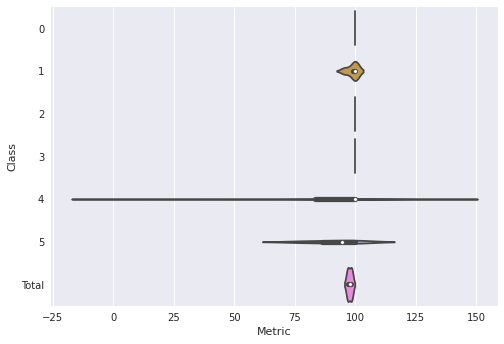

In [21]:
epochs = 100
masks_no = 80
mask_size = 7
target_size = 10
data_size = max_size

hyper_results = test_model(network_fn(epochs, masks_no, mask_size, target_size),
                    (X, y),
                    data_size,
                    None, 4)

In [22]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

149: 97.69 ~ 0.89, (max: 98.46)


In [48]:
hyper_results[hyper_results["Class"]=="ROC score"].reset_index(drop=True)

,Class,Metric


### Random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

149: nan ~ nan, (max: nan)


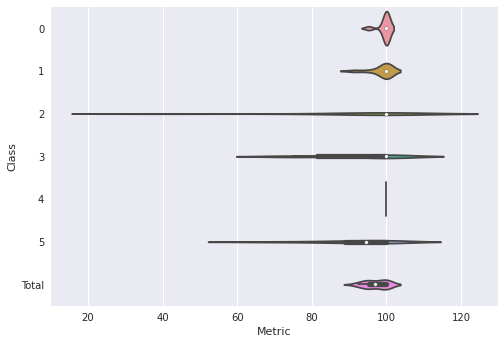

In [24]:
def get_rf():
    def _inner():
        random_seed = np.random.randint(1024)
        return RandomForestClassifier(
            random_state=random_seed)
    return _inner


for size in [max_size][::-1]:
    rf_dframe = test_model(get_rf(), 
                            (X, y),
                            size,
                            None, iters=10)
    res = rf_dframe[rf_dframe["Class"]=="ROC score"].reset_index(drop=True)["Metric"]
    print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

In [25]:
res = rf_dframe[rf_dframe["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

149: 97.08 ~ 2.94, (max: 100.00)
